In [1]:
username = 'MarcelloCeresini'
repository = 'QuestionAnswering'

# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip3 install transformers
    !apt install libomp-dev
    !pip3 install faiss
    !git clone https://www.github.com/{username}/{repository}.git
    #from google.colab import drive
    #drive.mount('/content/drive/')
    %cd /content/QuestionAnswering/src
    using_TPU = True    # If we are running this notebook on Colab, use a TPU
    # Google cloud credentials
    %env GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/Uni/Magistrale/NLP/Project/nlp-project-338723-0510aa0a4912.json
except:
    IN_COLAB = False
    using_TPU = False   # If you're not on Colab you probably won't have access to a TPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 33.9 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
     |████████████████████████████████| 101 kB 11.9 MB/s 
     |████████████████████████████████| 6.6 MB 56.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 19 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB o

# Imports

In [31]:
import os
import numpy as np
import random
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from typing import List, Union, Dict, Tuple
from transformers import BertTokenizerFast, DistilBertTokenizerFast, \
                         TFBertModel, TFDistilBertModel
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
import utils
import faiss
from collections import deque

RANDOM_SEED = 42
MAX_SEQ_LEN = 512
BERT_DIMENSIONALITY = 768
BATCH_SIZE = 8 if not using_TPU else 128

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

ROOT_PATH = os.path.dirname(os.getcwd())
TRAINING_FILE = os.path.join(ROOT_PATH, 'data', 'training_set.json')
VALIDATION_FILE = os.path.join(ROOT_PATH, 'data', 'validation_set.json')
TEST_FILE = os.path.join(ROOT_PATH, 'data', 'dev_set.json')

if using_TPU:
    try: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
        tf.config.experimental_connect_to_cluster(resolver)
        # This is the TPU initialization code that has to be at the beginning.
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        strategy = tf.distribute.TPUStrategy(resolver)
    except:
        print("TPUs are not available, setting flag 'using_TPU' to False.")
        using_TPU = False
        print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Question Answering with the DPR


We have trained the two Bert (`bert_p`, the paragraphs encoder and `bert_q`, the questions encoder) models to produce embeddings that are as similar as possible for matching question-paragraph pairs. 

Thanks to our training, when we use `bert_q` to encode our question, we will now be sure that questions and paragraphs will both be encoded in the same space and have a with the matching paragraph's encoding.

We can now use `bert_p` to encode all of our paragraphs a-priori using the same method we have used before (taking the 768-d encoding at the `[CLS]` token). 

Then, we can define our final Question Answering model in this way:
- It receives only a question's embedding as input.
- It uses `bert_q` to create a representation of the question in the learnt 768-d space, that is in common with the paragraph representations.
- We compute similarity scores between the representation of the question and all representations of paragraphs. Based on these scores, we select the top-k ($k=100$) paragraphs.
- For each of the $k$ paragraphs, we must compute the probability of the paragraph being selected $P_{selected}(i)$, as well as the usual $P_{start, i}(s), P_{end, i}(t)$ for each of the $s$-th and $t$-th words of the $i$-th paragraph. To do that, we need the full encoding of the paragraph (the $512 \times 768$ output of Bert), which will be denoted as $P_i$ in contrast to $\hat{P}_i$ which is the 768-d encoding at the `[CLS]` token. We obtain the full encoding by passing the $k$ paragraphs through `bert_p`, which is set to non-trainable (otherwise the encoding of the `[CLS]` token would constantly change). 
- All probabilities are computed through dense layers:
\begin{gather}
P_{start,i}(s) = softmax(P_i w_{start})_s
\\
P_{end,i}(t) = softmax(P_i w_{end})_t
\\
P_{selected}(i) = softmax(\hat{P}_i^\intercal w_{selected})_i
\\
\end{gather}
where $w_{start}$, $w_{end}$ and $w_{selected}$ are learnt vectors, while $\hat{P}_i = [P_{1}^{[CLS]}, \dots, P_k^{[CLS]}]$.
- As final answer, we select the highest scoring start-end legal span from the highest-scoring paragraph.

During training: For each question, we create a batch by sampling $m$ ($m=24$ in the paper) from the top-100 passages returned by the retrieval system (DPR, so by computing similarities with the pre-computed representations). The training objective is to maximize the marginal log-likelihood of all the correct answer spans in the positive passage (the answer string may appear multiple times in one passage), combined with the log-likelihood of the positive passage being selected. In the paper, a batch size of 16 was used.


# Setup

## Dataset Loading

We load all data that was prepared into the `dense_passage_retriever` notebook

In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    checkpoint_dir = '/content/drive/MyDrive/Uni/Magistrale/NLP/Project/weights/training_dpr/'
    datasets_dir = '/content/drive/MyDrive/Uni/Magistrale/NLP/Project/datasets/dpr/'
else:
    # Create the folder where we'll save the weights of the model
    checkpoint_dir = os.path.join("checkpoints", "training_dpr")
    datasets_dir = os.path.join("checkpoints", "training_dpr", "dataset")

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

Mounted at /content/drive/


In [4]:
train_paragraphs_and_questions = utils.read_question_set(TRAINING_FILE)['data']
val_paragraphs_and_questions = utils.read_question_set(VALIDATION_FILE)['data']
test_paragraphs_and_questions = utils.read_question_set(TEST_FILE)['data']

# Remove the validation set from the train set
train_paragraphs_and_questions = [article for article in train_paragraphs_and_questions \
                                  if article not in val_paragraphs_and_questions]

def get_questions_and_paragraphs(dataset):
    questions = [{
            'qas': qas,
            'context_id': (i,j)    # We also track the question's original context and paragraph indices so to have a ground truth
        }
        for i in range(len(dataset))
        for j, para in enumerate(dataset[i]['paragraphs'])
        for qas in para['qas']
    ]

    paragraphs = [{
            'context': para['context'],
            'context_id': i
        }
        for i in range(len(dataset))
        for para in dataset[i]['paragraphs']
    ]

    return questions, paragraphs

train_questions, train_paragraphs = get_questions_and_paragraphs(train_paragraphs_and_questions)
val_questions, val_paragraphs = get_questions_and_paragraphs(val_paragraphs_and_questions)
test_questions, test_paragraphs = get_questions_and_paragraphs(test_paragraphs_and_questions)

In [5]:
def decode_fn(record_bytes):
    # Reads one element from the dataset (as bytes) and decodes it in a tf.data Dataset element.
    example = tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {"question__input_ids": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "question__attention_mask": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "question__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
       "answer__out_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "answer__out_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__input_ids": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__attention_mask": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "hard_paragraph__input_ids": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "hard_paragraph__attention_mask": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__tokens_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__tokens_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "context__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
       "paragraph__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64)})
    return {
      "questions": {'input_ids': example['question__input_ids'],
                    'attention_mask': example['question__attention_mask'],
                    'index': example['question__index']},
      "answers":   {'out_s': example['answer__out_s'],
                    'out_e': example['answer__out_e']},
      "paragraphs":{'input_ids': example['paragraph__input_ids'],
                    'attention_mask': example['paragraph__attention_mask'],
                    'tokens_s': example['paragraph__tokens_s'],
                    'tokens_e': example['paragraph__tokens_e']},
      "hard_paragraphs": {'input_ids': example['hard_paragraph__input_ids'],
                          'attention_mask': example['hard_paragraph__attention_mask']},
      "context_ids": (example['context__index'], example['paragraph__index'])
    }

def load_tf_dataset_from_cloud(questions, fn, batch_size=BATCH_SIZE):
    # Prepare strings
    filename = f'{fn}_{BERT_DIMENSIONALITY}.proto'
    fn_type = filename.split(os.sep)[-1].replace('.proto','')
    dst_name = fn_type + '.proto'
    bucket_name = 'volpepe-nlp-project-squad-datasets'
    gcs_filename = f'gs://{bucket_name}/{dst_name}'
    print(f"Loading {fn_type} dataset from GCS ({gcs_filename}).")
    # Return it as processed dataset
    dataset = tf.data.TFRecordDataset([gcs_filename]).map(decode_fn)
    dataset = dataset.apply(tf.data.experimental.assert_cardinality(len(questions)))
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

dataset_train = load_tf_dataset_from_cloud(train_questions, os.path.join(datasets_dir, 'train'))
dataset_val = load_tf_dataset_from_cloud(val_questions, os.path.join(datasets_dir, 'val'))

Loading train_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/train_768.proto).
Loading val_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/val_768.proto).


## Model loading

In [6]:
tokenizer_distilbert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


class ReducedDistilBertModel(keras.Model):
    def __init__(self, distilbert_model):
        super(ReducedDistilBertModel, self).__init__()
        self.distilbert_model = distilbert_model
        self.reduction_layer = keras.layers.Dense(BERT_DIMENSIONALITY, 
                                                  activation='gelu')

    def call(self, inputs):
        hidden_state = self.distilbert_model(inputs).last_hidden_state
        # We introduce a dense layer that simply reduces the dimensionality of the model's output.
        # It's not used if the output dimensionality is the same of the Bert model
        return self.reduction_layer(hidden_state) if BERT_DIMENSIONALITY != 768 else hidden_state


class DenseEncoder(layers.Layer):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.model_q = model_q  # Dense encoder for questions
        self.model_p = model_p  # Dense encoder for paragraphs
    
    def call(self, inputs, training=False):
        # Encode the questions in the batch
        # Take the first token as representation of each question
        q_repr = self.model_q({
            'input_ids': inputs['questions']['input_ids'],
            'attention_mask': inputs['questions']['attention_mask']
        })[:,0,:]
        # If we are training, we also return the representation of the paragraphs
        # and of the hard paragraph
        if training:
            # Encode the batch of paragraphs
            p_repr = self.model_p({
                'input_ids': inputs['paragraphs']['input_ids'],
                'attention_mask': inputs['paragraphs']['attention_mask']
            })[:,0,:]
            # We also encode the batch of hard paragraphs separately. 
            p_hard_repr = self.model_p({
                'input_ids': inputs['hard_paragraphs']['input_ids'],
                'attention_mask': inputs['hard_paragraphs']['attention_mask']
            })[:,0,:]
            return q_repr, p_repr, p_hard_repr
        else:
            return q_repr


class DeepQPEncoder(keras.Model):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        if training:
            # For training we return the similarity matrix
            repr_q, repr_p, repr_hard_p = self.enc(inputs, training=training)
            S = tf.tensordot(repr_q, tf.transpose(repr_p), axes=1)
            # We append the hard scores
            hard_scores = tf.gather(
                # Get the elements on the diagonal of the 8x8 matrix of 
                # scores between questions and hard paragraphs
                tf.tensordot(repr_q, tf.transpose(repr_hard_p), axes=1), 
                    tf.expand_dims(
                        tf.range(tf.shape(inputs['questions']['input_ids'])[0]), 
                        axis=1), 
                    batch_dims=1
            )
            S = tf.concat([S, hard_scores], axis=1)
            return S
        else:
            # In other cases, we return the representation of the question(s)
            repr_q = self.enc(inputs, training=training)            
            return repr_q

    def train_step(self, data):
        x = data
        # y = [0, ..., batch_size-1]
        y = tf.range(tf.shape(x['questions']['input_ids'])[0])
        with tf.GradientTape() as tape:
            # Obtain similarities
            S = self(x, training=True)
            # Obtain loss value
            loss = self.compiled_loss(y, S)
        # Construct gradients and apply them through the optimizer
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(y, S)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        # y = [0, ..., batch_size-1]
        y = tf.range(tf.shape(x['questions']['input_ids'])[0])
        S = self(x, training=True) # We are not really training, but we have to obtain S
        self.compiled_loss(y, S)
        self.compiled_metrics.update_state(y, S)
        return {m.name: m.result() for m in self.metrics}


def create_dpr(sample, freeze_layers_up_to=5):
    print("Creating BERT models...")
    model_q, model_p =  TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                        TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Freeze layers 
    for i in range(freeze_layers_up_to): # layers 0 to variable are frozen, successive layers learn
        model_q.distilbert.transformer.layer[i].trainable = False
        model_p.distilbert.transformer.layer[i].trainable = False

    model_q, model_p = ReducedDistilBertModel(model_q), ReducedDistilBertModel(model_p)

    print("Creating Deep Encoder...")
    model = DeepQPEncoder(model_q, model_p)

    print("Compiling...")
    # Compile the model and loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-6),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )

    print("Testing on some data...")
    # Pass one batch of data to build the model
    model(sample)

    # Return the model
    print("Model created!")
    return model

In [7]:
dpr_model_name = f'dpr_{BERT_DIMENSIONALITY}_hard'
dpr_checkpoint_path = os.path.join(checkpoint_dir, dpr_model_name + ".ckpt")
local_device_option = tf.train.CheckpointOptions(
    experimental_io_device="/job:localhost")

if using_TPU:
    # TPU requires to create the model within the scope of the distributed strategy
    # we're using.
    with strategy.scope():
        dpr_model = create_dpr(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)
else:
    # On TPU we cannot use tensorboard, but on GPU we can
    log_dir = os.path.join(ROOT_PATH, "data", "logs", 
        f"training_dpr_{BERT_DIMENSIONALITY}_hard", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    dpr_model = create_dpr(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)

Creating BERT models...


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

Creating Deep Encoder...
Compiling...
Testing on some data...
Model created!


In [8]:
# Load the obtained weights
dpr_model.load_weights(dpr_checkpoint_path, options=local_device_option)

## Question Answering model

We pre-tokenize the paragraphs so that we have easy access to them inside the model.

In [9]:
pretokenized_paragraphs = {
    'train': {
        'input_ids': [],
        'attention_mask': [],
        'offset_mapping': []
    },
    'val': {
        'input_ids': [],
        'attention_mask': [],
        'offset_mapping': []
    }
}

for i in tqdm(range(len(train_paragraphs))):
    token_p = dict(tokenizer_distilbert(
        train_paragraphs[i]['context'], max_length = MAX_SEQ_LEN, 
        return_tensors='tf', truncation = True, 
        padding = 'max_length', return_offsets_mapping = True
    ))
    pretokenized_paragraphs['train']['input_ids'].append(token_p['input_ids'])
    pretokenized_paragraphs['train']['attention_mask'].append(token_p['attention_mask'])
    pretokenized_paragraphs['train']['offset_mapping'].append(token_p['offset_mapping'])

for i in tqdm(range(len(val_paragraphs))):
    token_p = dict(tokenizer_distilbert(
        train_paragraphs[i]['context'], max_length = MAX_SEQ_LEN, 
        return_tensors='tf', truncation = True, 
        padding = 'max_length', return_offsets_mapping = True
    ))
    pretokenized_paragraphs['val']['input_ids'].append(token_p['input_ids'])
    pretokenized_paragraphs['val']['attention_mask'].append(token_p['attention_mask'])
    pretokenized_paragraphs['val']['offset_mapping'].append(token_p['offset_mapping'])

100%|██████████| 4921/4921 [00:03<00:00, 1517.66it/s]


Then, we define a function to create the model. The model should accept the top paragraphs encodings collected using the DPR and return their start, end and selection probabilities.

Note that at training time, this is the only part that learns. We assume that the rest is fixed. We use FAISS to index the best paragraph for each encoded question.

In [10]:
class BestScoringCollector(keras.layers.Layer):
    '''
    Custom layer to collect the start and end probabilities from the best scoring
    paragraph
    '''
    def __init__(self, **kwargs):
        super(BestScoringCollector, self).__init__(trainable=False, **kwargs)

    def call(self, probs_s, probs_e, probs_sel):
        # Selection of best scoring paragraphs
        best_scoring_paragraphs = tf.squeeze(tf.argmax(probs_sel, axis=1, output_type=tf.int32))
        # Selection of related start-end probabilities
        probs_s = tf.squeeze(tf.gather(probs_s, indices=tf.expand_dims(best_scoring_paragraphs, -1), batch_dims=1))
        probs_e = tf.squeeze(tf.gather(probs_e, indices=tf.expand_dims(best_scoring_paragraphs, -1), batch_dims=1))
        return probs_s, probs_e

def create_QA_model(m):
    # Receives in input the top paragraph full and search encodings collected using the DPR.
    paragraphs_full_encodings = keras.Input(shape=(m, MAX_SEQ_LEN, BERT_DIMENSIONALITY), 
        dtype='float32', name="topm_full_encodings")
    paragraphs_search_encodings = keras.Input(shape=(m, BERT_DIMENSIONALITY), 
        dtype='float32', name="topm_search_encodings")

    # Compute probabilities for the start token
    out_S = keras.layers.TimeDistributed(keras.layers.Dense(1), name="start_token_logits")(paragraphs_full_encodings)
    out_S = keras.layers.Reshape((m, MAX_SEQ_LEN))(out_S)
    out_S = keras.layers.Softmax(name="start_probs", axis=1, dtype='float32')(out_S)

    # The same is done for the end tokens.
    out_E = keras.layers.TimeDistributed(keras.layers.Dense(1), name="end_token_logits")(paragraphs_full_encodings)
    out_E = keras.layers.Reshape((m, MAX_SEQ_LEN))(out_E)
    out_E = keras.layers.Softmax(name="end_probs", axis=1, dtype='float32')(out_E)

    # Also, we compute paragraph selection probabilities
    out_SEL = keras.layers.Dense(1, name="selection_logits")(paragraphs_search_encodings)
    out_SEL = keras.layers.Flatten('channels_first')(out_SEL)
    out_SEL = keras.layers.Softmax(name="selection_probs", dtype='float32')(out_SEL)

    out_S, out_E = BestScoringCollector(name='best_scoring_collector')(out_S, out_E, out_SEL)

    # We return the keras model
    model = keras.Model(
        inputs = [paragraphs_full_encodings, paragraphs_search_encodings],
        outputs = [out_S, out_E, out_SEL]
    )

    return model

We analyze the model.

In [11]:
M = 24              # Number of paragraphs to be collected by the DPR (24 in the paper)

model_qa = create_QA_model(M)

In [12]:
model_qa.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 topm_full_encodings (InputLaye  [(None, 24, 512, 76  0          []                               
 r)                             8)]                                                               
                                                                                                  
 topm_search_encodings (InputLa  [(None, 24, 768)]   0           []                               
 yer)                                                                                             
                                                                                                  
 start_token_logits (TimeDistri  (None, 24, 512, 1)  769         ['topm_full_encodings[0][0]']    
 buted)                                                                                       

The outputs are of the expected shape. We also use an utility to see the model visually.

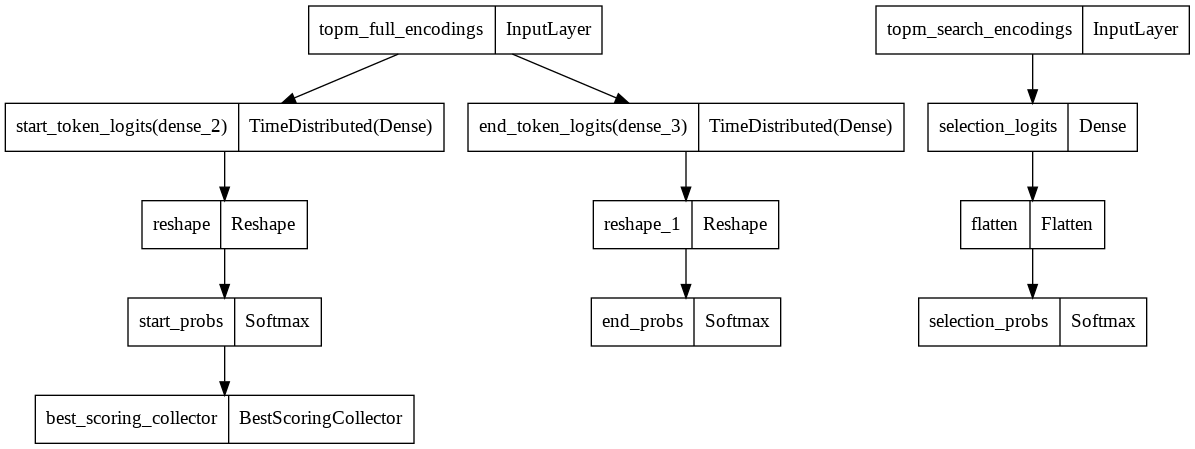

In [13]:
keras.utils.plot_model(model_qa, "multi_input_and_output_model.png")

### Model input

The input to the model are pre-encoded paragraph encodings. The encoding happens with the pre-trained `model_q` that we previously trained in the `dense_passage_retriever` notebook. We don't use a neural model anymore to retrieve the best scoring paragraphs: instead we have created a "pre-trained" FAISS index on the encodings of `model_p` for all paragraphs. In this way we can efficiently collect the best paragraphs given one or a sequence of queries (`model_q` encodings).

In [14]:
train_index = faiss.read_index(os.path.join(datasets_dir, 'indices', 'train_index'))
val_index   = faiss.read_index(os.path.join(datasets_dir, 'indices', 'val_index'))
test_index  = faiss.read_index(os.path.join(datasets_dir, 'indices', 'test_index'))

We try out our method. First of all we build a function to map `context_ids` to paragraph indices in the matrix.

In [32]:
# Map context ids to ground truth paragraph indexes
def get_paragraph_encoding_index(questions, dataset):
    art_ids, par_ids = questions['context_ids']
    idxs = deque([])
    for i in range(len(art_ids)):
        idxs.append(sum([len(dataset[j]['paragraphs']) for j in range(art_ids[i])]) + par_ids[i])
    return idxs

Then we take a batch of training data and test our method on it.

In [33]:
input_data = next(dataset_train.take(1).as_numpy_iterator())
qs = input_data['questions']
qs_representations = dpr_model.enc.model_q({
        'input_ids': qs['input_ids'], 
        'attention_mask': qs['attention_mask']
    })[:,0,:].numpy()
qs_representations.shape

Search using the index:

In [35]:
distances, best_indices = train_index.search(qs_representations, 100)
distances.shape, best_indices.shape

((128, 100), (128, 100))

The search is quite fast! Let's see if it's also accurate...

In [41]:
gt_paragraphs = get_paragraph_encoding_index(input_data, train_paragraphs_and_questions)
list(gt_paragraphs)[:5] # Show the first 5 ground truth paragraph IDs

[178, 345, 48, 675, 423]

We check where is the ground truth paragraph in the collection of best indices returned by our index.

Found 48 indices, while 80 were not found.


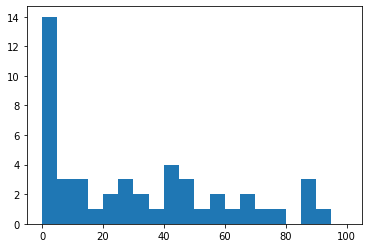

In [62]:
import matplotlib.pyplot as plt


count_found = 0
count_not_found = 0
found_where = []
for i in range(len(gt_paragraphs)):
    index = np.where(best_indices[i] == gt_paragraphs[i])[0]
    if len(index) > 0:
        # Element was found in those returned by the index
        count_found += 1
        found_where.append(index[0])
    else:
        count_not_found += 1

print(f"Found {count_found} indices, while {count_not_found} were not found.")
plt.hist(found_where, bins=range(0,105,5));

The results for this batch are not particularly good, but the search is quite efficient.

# The rest of it

The Dense Passage retriever returns indices of paragraphs, which we can collect using this function:

In [ ]:
def collect_paragraphs_from_dpr(pretokenized_paragraphs, paragraphs_encodings, indices):
    # Collect paragraphs. Inputs is the batch of paragraph indexes to gather
    paragraphs = {
        'input_ids': tf.squeeze(tf.gather(pretokenized_paragraphs['input_ids'], indices), axis=2),
        'attention_mask': tf.squeeze(tf.gather(pretokenized_paragraphs['attention_mask'], indices), axis=2),
        'offset_mapping': tf.squeeze(tf.gather(pretokenized_paragraphs['offset_mapping'], indices), axis=2),
        'indexes': indices
    }
    # Collect paragraph representations and their search encodings
    paragraphs_full_encodings = np.take(paragraphs_encodings, indices, axis=0)
    paragraphs_search_encodings = paragraphs_full_encodings[:,:,0,:]
    return paragraphs, paragraphs_full_encodings, paragraphs_search_encodings

In [ ]:
ps, full_enc, search_enc = \
    collect_paragraphs_from_dpr(pretokenized_paragraphs, paragraphs_encoding, top_m_indices)

So we can create a dataset like this:

In [ ]:
def create_qa_dataset(questions, fn, model_q, paragraphs_encodings, pretokenized_paragraphs):
    # Instantiate DPR
    dpr = DensePassageRetriever(model_q, paragraphs_encodings)
    # Read dataset from cloud disk
    filename = f'{fn}_v3_{BERT_DIMENSIONALITY}.proto'
    fn_type = filename.split(os.sep)[-1].replace('.proto','')
    gcs_filename = f'gs://volpepe-nlp-project-squad-datasets/{fn_type}.proto'
    
    if OVERWRITE_DATASETS_QA:
        print("Pre-tokenizing data...")
        tok_questions, tok_paragraphs = pre_tokenize_data(questions, full_dict, tokenizer_distilbert)
        assert len(tok_questions) == len(tok_paragraphs), "Error while pre-tokenizing dataset"
        print("Preprocessing answers...")
        answer_tokens = [find_start_end_token_one_hot_encoded(
            questions[i]['qas']['answers'], tok_paragraphs[i]['offset_mapping'])
        for i in tqdm(range(len(questions)))]
        print("Saving dataset on disk...")
        with tf.io.TFRecordWriter(filename) as file_writer:
            for i in tqdm(range(len(tok_questions))):
                question_ids = tok_questions[i]["input_ids"]
                question_attention_mask = tok_questions[i]["attention_mask"]
                # Create the DPR inputs
                dpr_inputs = {
                    'questions': { 
                        'input_ids': np.array(question_ids),
                        'attention_mask': np.array(question_attention_mask)
                    }
                }
                # Retrieve scores and top indices by calling the DPR
                scores, top_m_indices = dpr(dpr_inputs)
                # Obtain the paragraphs and their encodings by calling the collect function
                ps, full_enc, search_enc = \
                    collect_paragraphs_from_dpr(pretokenized_paragraphs, paragraphs_encodings, top_m_indices)
                
                record_bytes = tf.train.Example(features=tf.train.Features(feature={
                    "question__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=question_ids)),
                    "question__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=question_attention_mask)),
                    "answer__out_s": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_S"])),
                    "answer__out_e": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_E"])),
                    "paragraph__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[get_paragraph_global_id_from_question(questions[i], paragraphs)])),
                    "paragraph__full_enc": tf.train.Feature(bytes_list=tf.train.BytesList(
                        value=[tf.io.serialize_tensor(np.asarray(full_enc)).numpy()])),
                    "paragraph__tokens_s": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[0] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "paragraph__tokens_e": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[1] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "dpr__top_m_indices": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=list(tf.squeeze(top_m_indices)))),
                    })).SerializeToString()
                file_writer.write(record_bytes)
        print("Upload the dataset on Google Cloud and re-run the function")
        return None
    
    def decode_qa_fn(record_bytes):
        # Read example from bytes dataset
        example = tf.io.parse_single_example(
            # Data
            record_bytes,
            # Schema
            {"question__input_ids": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "question__attention_mask": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "answer__out_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "answer__out_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "paragraph__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
            "paragraph__full_enc": tf.io.FixedLenFeature([], dtype=tf.string),
            "paragraph__tokens_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "paragraph__tokens_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
            "dpr__top_100_indices": tf.io.FixedLenFeature(shape=(100, ), dtype=tf.int64)
           })
        
        # Yield the final dictionary structured however we need
        return {
            'questions': {
                'input_ids': example['question__input_ids'],
                'attention_mask': example['question__attention_mask']
            },
            'answers': {
                'out_s': example['answer__out_s'],
                'out_e': example['answer__out_e']
            },
            'paragraphs': {
                'index': example['paragraph__index'],
                'full_enc': tf.io.parse_tensor(example['paragraph__full_enc'], out_type=tf.float32),
                'search_enc': tf.io.parse_tensor(example['paragraph__search_enc'], out_type=tf.float32),
                'tokens_s': example['paragraph__tokens_s'],
                'tokens_e': example['paragraph__tokens_e']
            },
            'dpr': {
                'top_100_indices': example['dpr__top_100_indices']
            }
        }
    
    print(f"Loading {fn_type} dataset from GCS ({gcs_filename}).")
    # Return it as processed dataset
    dataset = tf.data.TFRecordDataset([gcs_filename]).map(decode_qa_fn)
    dataset = dataset.cache()
    dataset = dataset.shuffle(10000)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.apply(tf.data.experimental.assert_cardinality(len(questions)))
    dataset = dataset.batch(batch_size)
    return dataset

dataset_train_qa = create_qa_dataset(train_questions, os.path.join(datasets_dir, 'train_qa'), 
                                    model.enc.model_q, paragraphs_encoding, pretokenized_paragraphs)
dataset_val_qa = create_qa_dataset(val_questions, os.path.join(datasets_dir, 'val_qa'), 
                                  model.enc.model_q, paragraphs_encoding, pretokenized_paragraphs)

Pre-tokenizing data...


100%|██████████████████████████████████████████████████████████████████████████| 65064/65064 [00:32<00:00, 2019.01it/s]


Preprocessing answers...


100%|█████████████████████████████████████████████████████████████████████████| 65064/65064 [00:01<00:00, 43289.41it/s]


Saving dataset on disk...


  0%|                                                                           | 54/65064 [13:57<492:30:07, 27.27s/it]

In [ ]:
dataset_train_qa

<BatchDataset element_spec={'questions': {'input_ids': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'index': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}, 'answers': {'out_s': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'out_e': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None)}, 'paragraphs': {'input_ids': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'tokens_s': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'tokens_e': TensorSpec(shape=(None, 400), dtype=tf.int64, name=None), 'index': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}}>

In [ ]:
def create_qa_datasets(, model_q, paragraphs_encodings, pretokenized_paragraphs):

    def qa_dataset_generator(dataset):
        # Instantiate DPR
        dpr = DensePassageRetriever(model_q, paragraphs_encodings)
        # Instantiate dataset iterator
        dataset = dataset.as_numpy_iterator()
        # Iterator over regular dataset
        for el in dataset:
            # Retrieve scores and top indices by calling the DPR
            scores, top_m_indices = dpr(el)
            # Obtain the paragraphs and their encodings by calling the collect function
            paragraphs, full_enc, search_enc = \
                collect_paragraphs_from_dpr(pretokenized_paragraphs, paragraphs_encodings, top_m_indices)
            # Yield the collected elements
            gt_indices = el['paragraphs']['index']
            gt_start = el['answers']['out_s']
            gt_end = el['answers']['out_e']
            yield {
                'gt_indices': gt_indices, 
                'gt_start': gt_start,
                'gt_end': gt_end,
                'top_m_indices': top_m_indices,
                'full_enc': full_enc, 
                'search_enc': search_enc
            }

    signature = {
        'gt_indices': tf.TensorSpec(shape=(BATCH_SIZE, ), dtype=tf.int32), 
        'gt_start': tf.TensorSpec(shape=(BATCH_SIZE, MAX_SEQ_LEN), dtype=tf.int32),
        'gt_end': tf.TensorSpec(shape=(BATCH_SIZE, MAX_SEQ_LEN), dtype=tf.int32),
        'top_m_indices': tf.TensorSpec(shape=(BATCH_SIZE, 100, ), dtype=tf.int32),
        'full_enc': tf.TensorSpec(shape=(BATCH_SIZE, 100, MAX_SEQ_LEN, BERT_DIMENSIONALITY), dtype=tf.float32), 
        'search_enc': tf.TensorSpec(shape=(BATCH_SIZE, 100, BERT_DIMENSIONALITY), dtype=tf.float32)
    }

    qa_dataset_train = tf.data.Dataset.from_generator(partial(
            qa_dataset_generator, dataset_train), 
        output_signature=signature)
    qa_dataset_val = tf.data.Dataset.from_generator(partial(
            qa_dataset_generator, dataset_val), 
        output_signature=signature)
    
    qa_dataset_train.apply(tf.data.experimental.assert_cardinality(len(dataset_train)))
    qa_dataset_val.apply(tf.data.experimental.assert_cardinality(len(dataset_val)))

    # No need to batch the dataset, it's already batched.
    qa_dataset_train = qa_dataset_train.cache()
    qa_dataset_train = qa_dataset_train.shuffle(10000)
    qa_dataset_train = qa_dataset_train.prefetch(tf.data.AUTOTUNE)
    
    qa_dataset_val = qa_dataset_val.cache()
    qa_dataset_val = qa_dataset_val.shuffle(10000)
    qa_dataset_val = qa_dataset_val.prefetch(tf.data.AUTOTUNE)

    return qa_dataset_train, qa_dataset_val

In [ ]:
qa_dataset_train, qa_dataset_val = create_qa_datasets(
    dataset_train, dataset_val, model.enc.model_q, paragraphs_encoding, pretokenized_paragraphs
)

In [ ]:
next(qa_dataset_train.take(1).as_numpy_iterator())

### Training

To train the model we need to:

- Compile it defining the losses and optimizer.
- Create a ground truth batch that we use for comparing the model's output.

We define custom training and testing functions.

In [ ]:
# Metrics (create under the strategy scope if using TPU)
if using_TPU:
    with strategy.scope():
        loss_tracker = keras.metrics.Mean(name="loss")
        start_acc_metric = keras.metrics.CategoricalAccuracy(name="start_token_accuracy")
        end_acc_metric = keras.metrics.CategoricalAccuracy(name="end_token_accuracy")
        sel_acc_metric = keras.metrics.CategoricalAccuracy(name="par_selection_accuracy")
else:
    loss_tracker = keras.metrics.Mean(name="loss")
    start_acc_metric = keras.metrics.CategoricalAccuracy(name="start_token_accuracy")
    end_acc_metric = keras.metrics.CategoricalAccuracy(name="end_token_accuracy")
    sel_acc_metric = keras.metrics.CategoricalAccuracy(name="par_selection_accuracy")

class QuestionAnsweringModel(keras.Model):
    def __init__(self, m=M):
        super(QuestionAnsweringModel, self).__init__()
        self.model_qa = create_QA_model(m)
    
    def call(self, inputs):
        return inputs['top_m_indices'], self.model_qa({
            'topm_full_encodings': inputs['full_enc'],
            'topm_search_encodings': inputs['search_enc']
        })

    @tf.function
    def tf_shuffle_on_columns(self, value):
        '''
        Utility function that shuffles a tensor randomly on each of its rows.
        '''
        # Create a tensor of random numbers, argsort it and use them as indices to gather
        # values from the original tensor
        return tf.gather(value, tf.argsort(tf.random.uniform(tf.shape(value))), batch_dims=1)

    @tf.function
    def obtain_training_info(self, indexes, topm_indexes):
        '''
        Obtains a batch of data and the ground truth mask to be used while training the model
        '''
        # Collect ground truth indexes
        gt_paragraphs = tf.expand_dims(tf.cast(indexes, tf.int32), -1)
        # A training sample is formed by the positive and m-1 negative examples
        # obtained from the top-100 for each of the questions in the batch.
        # We create a data batch by sampling m-1 examples from the masked 100 paragraphs
        negative_masks = tf.math.not_equal(topm_indexes, gt_paragraphs)
        # To keep the graph working with the correct sizes, we create a tensor of negatives 
        # by random shuffling the large tensor of topm and taking the first train_m elements.
        # The positive examples are replaced by randomly sampling from the same tensor.
        # It could happen that the positive example is replaced by itself, or that a 
        # negative sample appears twice in the batch, but it's a non-deterministic
        # process.
        negatives = self.tf_shuffle_on_columns(tf.where(
            negative_masks, topm_indexes, self.tf_shuffle_on_columns(topm_indexes))
        )[:,:M-1]
        # We concatenate the positive paragraph index to the selected negatives and shuffle
        # so that the positive is not always the last element
        data_batch = self.tf_shuffle_on_columns(
            tf.concat([negatives, gt_paragraphs], axis=1))
        # When we have a data batch, we create the ground truth mask, which represents the position
        # of the positive sample in the data batch in a one-hot encoded fashion.
        gt_mask = tf.cast(data_batch == gt_paragraphs, tf.int32)
        return data_batch, gt_mask

    def train_step(self, data):
        # Obtain the training batch and the ground truth mask
        data_batch, gt_mask = self.obtain_training_info(
            data['gt_indices'], data['top_m_indices'])
        # Open the gradient tape, obtain predictions and compute the loss
        with tf.GradientTape() as tape:
            _, out_S, out_E, out_SEL = self(data_batch, training=True)
            loss_start = self.compiled_loss(data['gt_start'], out_S)
            loss_end = self.compiled_loss(data['gt_end'], out_E)
            loss_sel = self.compiled_loss(gt_mask, out_SEL)
            loss_value = sum([loss_start, loss_end, loss_sel])
        # Compute the gradients and apply them on the variables
        grads = tape.gradient(loss_value, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update the metrics
        loss_tracker.update_state(loss_value)
        start_acc_metric.update_state(data['gt_start'], out_S)
        end_acc_metric.update_state(data['gt_end'], out_E)
        sel_acc_metric.update_state(gt_mask, out_SEL)
        return {"loss": loss_tracker.result(), 
                "start_accuracy": start_acc_metric.result(),
                "end_accuracy": end_acc_metric.result(),
                "sel_accuracy": sel_acc_metric.result()}

    def test_step(self, data):
        # Obtain the training batch and the ground truth mask to compute metrics
        data_batch, gt_mask = self.obtain_training_info(
            data['gt_indices'], data['top_m_indices'])
        # Compute predictions
        _, out_S, out_E, out_SEL = self(data_batch, training=False)
        # Compute the loss to update its metric
        loss_start = self.compiled_loss(data['gt_start'], out_S)
        loss_end = self.compiled_loss(data['gt_end'], out_E)
        loss_sel = self.compiled_loss(gt_mask, out_SEL)
        loss_value = sum([loss_start, loss_end, loss_sel])
        loss_tracker.update_state(loss_value)
        # Updates the metrics
        start_acc_metric.update_state(data['gt_start'], out_S)
        end_acc_metric.update_state(data['gt_end'], out_E)
        sel_acc_metric.update_state(gt_mask, out_SEL)
        # Return a dict mapping metric names to current value.
        return {"loss": loss_tracker.result(), 
                "start_accuracy": start_acc_metric.result(),
                "end_accuracy": end_acc_metric.result(),
                "sel_accuracy": sel_acc_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        return [loss_tracker, start_acc_metric, end_acc_metric, sel_acc_metric]

def create_trainable_QA_model(model_q):
    print("Creating Question Answering model...")
    model = QuestionAnsweringModel(model_q)

    print("Compiling...")
    # Compile the model (metrics are defined into the model)
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=3e-6),
        loss = keras.losses.CategoricalCrossentropy()
    )

    print("Testing on some data...")
    # Pass one batch of test data to build the model
    inputs = next(qa_dataset_train.take(1).as_numpy_iterator())
    top_m_indices, probs_sel, probs_s, probs_e = model(inputs)
    
    print("Output shapes:")
    print(f"\tparagraphs: {top_m_indices.shape}")
    print(f"\tprobs_sel: {probs_sel.shape}")
    print(f"\tprobs_s: {probs_s.shape}")
    print(f"\tprobs_e: {probs_e.shape}")

    model.summary()

    return model

In [ ]:
import datetime

if using_TPU:
    # TPU requires to create the model within the scope of the distributed strategy
    # we're using.
    with strategy.scope():
        model_QA = create_trainable_QA_model(model.enc.model_q, pretokenized_paragraphs, paragraphs_encoding)

    # Workaraound for saving locally when using cloud TPUs
    local_device_option = tf.train.CheckpointOptions(
        experimental_io_device="/job:localhost")
else:
    # GPUs and local systems don't need the above specifications. We simply
    # create a pattern for the filename and let the callbacks deal with it.
    checkpoint_path = os.path.join(checkpoint_dir, "model_qa_cp-{epoch:04d}.ckpt")
    # Also, on TPU we cannot use tensorboard, but on GPU we can
    log_dir = os.path.join(ROOT_PATH, "data", "logs", 
        "training_qa_dpr", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    model_QA = create_trainable_QA_model(model.enc.model_q, pretokenized_paragraphs, paragraphs_encoding)

Creating Question Answering model...
Compiling...
Testing on some data...


InternalError: Exception encountered when calling layer "dense_passage_retriever_2" (type DensePassageRetriever).

Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Call arguments received:
  • inputs={'questions': {'input_ids': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'index': 'tf.Tensor(shape=(4,), dtype=int64)'}, 'answers': {'out_s': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'out_e': 'tf.Tensor(shape=(4, 400), dtype=int64)'}, 'paragraphs': {'input_ids': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'tokens_s': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'tokens_e': 'tf.Tensor(shape=(4, 400), dtype=int64)', 'index': 'tf.Tensor(shape=(4,), dtype=int64)'}}

Train the model:

In [ ]:
QA_BATCH_SIZE = 4 if not using_TPU else 32

dataset_train = create_dataset_from_records(train_questions, paragraphs, train_dict, tokenizer_distilbert, 
                                            os.path.join(datasets_dir, 'train'), batch_size=QA_BATCH_SIZE)
dataset_val = create_dataset_from_records(val_questions, paragraphs, val_dict, tokenizer_distilbert,
                                            os.path.join(datasets_dir, 'val'), training=False, batch_size=QA_BATCH_SIZE)

if DO_QA_TRAINING:
    # Early stopping can be used by both hardware
    es_callback = tf.keras.callbacks.EarlyStopping(
        patience = PATIENCE,
        restore_best_weights=True
    )
    callbacks = [es_callback]
    if not using_TPU:
        # ModelCheckpoint callback is only available when not using TPU
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_path,
            verbose=1,
            save_weights_only = True,
            save_best_only = False
        )
        # Same for tensorboard callback
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )
        # Save the first weights using the pattern from before
        model_QA.save_weights(checkpoint_path.format(epoch=0))
        # These callback imply saving stuff on local disk, which cannot be 
        # done automatically using TPUs.
        # Therefore, they are only active when using GPUs and local systems
        callbacks.extend([cp_callback, tensorboard_callback])
    else:
        # Save first weights in a h5 file (it's the most stable way)
        model_QA.save_weights(os.path.join(
            checkpoint_dir, 'training_qa_tpu_0.h5'), overwrite=True)        

    # We fit the model
    history = model_QA.fit(
        dataset_train, 
        y=None,
        validation_data=dataset_val,
        epochs=EPOCHS, 
        callbacks=callbacks,
        shuffle=True,
        use_multiprocessing=True,
        initial_epoch=0,
        verbose=1 # Show progress bar
    )

    if using_TPU:
        # Save last weights
        model_qa.save_weights(os.path.join(
            checkpoint_dir, 'training_qa_tpu_last.h5'), overwrite=True)

### Obtaining an answer

In [ ]:
def start_end_token_from_probabilities(
    pstartv: np.array, 
    pendv: np.array, 
    dim:int=512) -> List[List[int]]:
    '''
    Returns a List of [StartToken, EndToken] elements computed from the batch outputs.
    '''
    idxs = []
    for i in range(pstartv.shape[0]):
        # For each element in the batch, transform the vectors into matrices
        # by repeating them dim times:
        # - Vectors of starting probabilities are stacked on the columns
        pstart = np.stack([pstartv[i,:]]*dim, axis=1)
        # - Vectors of ending probabilities are repeated on the rows
        pend = np.stack([pendv[i,:]]*dim, axis=0)
        # Once we have the two matrices, we sum them (element-wise operation)
        # to obtain the scores of each combination
        sums = pstart + pend
        # We only care about the scores in the upper triangular part of the matrix
        # (where the ending index is greater than the starting index)
        # therefore we zero out the diagonal and the lower triangular area
        sums = np.triu(sums, k=1)
        # The most probable set of tokens is the one with highest score in the
        # remaining matrix. Through argmax we obtain its position.
        val = np.argmax(sums)
        # Since the starting probabilities are repeated on the columns, each element
        # is identified by the row. Ending probabilities are instead repeated on rows,
        # so each element is identified by the column.
        row = val // dim
        col = val - dim*row
        idxs.append([row,col])
    return idxs

In [ ]:
answers_start_end = start_end_token_from_probabilities(probs_s, probs_e)
print(answers_start_end)

Finally, we can obtain the answers to the questions we have given the network.

In [ ]:
best_indices = tf.squeeze(tf.gather(paragraphs['indexes'], tf.expand_dims(best_scoring_paragraphs, -1), batch_dims=1))
best_offsets = tf.squeeze(tf.gather(pretokenized_val_paragraphs['offset_mapping'], best_indices))
best_offsets.shape, best_indices.shape

In [ ]:
char_start_end = [(best_offsets[i][answers_start_end[i][0]][0].numpy(),
                   best_offsets[i][answers_start_end[i][1]][1].numpy())
                 for i in range(BATCH_SIZE)]
char_start_end

In [ ]:
# Correction for answers arriving to the end of the sequence
for i in range(BATCH_SIZE):
    c = char_start_end[i]
    if c[1] >= c[0]:
        char_start_end[i] = (c[0], c[1])
    else:
        char_start_end[i] = (c[0], 1000000)

In [ ]:
for i, p in enumerate(best_indices.numpy()):
    print(val_paragraphs[p]['context'][char_start_end[i][0]:char_start_end[i][1]])

Of course, answers are extremely bad because we need to train the Dense layers selecting the start and end tokens, as well as the paragraph selector.